In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
import keras_tuner as kt
from tensorflow.keras import backend as K
import shutil

shutil.rmtree("kt_dir", ignore_errors=True)
K.clear_session()

In [ ]:
# name of city - used only in output file name
city="Kolkata"
# load result from 2.0 training_to_parquet
training_data_file = r""

# load result from 1.0 real data
real_data_file = r""

# define name/path where classification report should be saved - no extension -> will be added in the code
classification_rpt = r""

# define name/path where confusion matrix should be saved.
confusion_mtrx = r""

# output geojson file
output_file = r""

#### Train Data Set

In [6]:
# Load your dataset (replace with your actual file)
# load result from 2.0 training_to_parquet
# df = pd.read_parquet(training_data_file)
df = pd.read_csv(training_data_file)
# df.to_csv("data/origData/results/split_universe_with_median_height.csv") - better use parquet

# drop unused columns, leave only the ones needed for computation
df_adjusted = df.drop(
    columns=[
        "Unnamed: 0.1",
        "Unnamed: 0",
        "id",
        "geometry",
        "polygon",
        "tile",
    ]
)

df_cleaned = df_adjusted.fillna(0)

# Normalize data
df_cleaned["avg_area_norm"] = df_cleaned["avg_area"] / 3000
df_cleaned.loc[df_cleaned["avg_area"] > 3000, "avg_area_norm"] = 1

df_cleaned["max_area_norm"] = df_cleaned["max_area"] / 3000
df_cleaned.loc[df_cleaned["max_area"] > 3000, "max_area_norm"] = 1

df_cleaned["avg_height_norm"] = df_cleaned["avg_height"] / 100
df_cleaned.loc[df_cleaned["avg_height"] > 3000, "avg_height_norm"] = 1

df_cleaned = df_cleaned.drop(columns=["avg_area", "max_area", "avg_height"])

print(df_cleaned.columns)
print(df_cleaned.head(3))

Index(['class', 'count', 'num_pixels_ge_3m', 'avg_area_norm', 'max_area_norm',
       'avg_height_norm'],
      dtype='object')
    class  count  num_pixels_ge_3m  avg_area_norm  max_area_norm  \
0  formal      4                61       0.114905       0.155571   
1  formal      3               190       0.125668       0.309562   
2  formal      1               141       0.690877       0.690877   

   avg_height_norm  
0           0.0975  
1           0.0650  
2           0.1050  


In [7]:
# Separate features (X) and label (y)
X = df_cleaned.drop("class", axis=1)
y = df_cleaned["class"]

y = y.map({"formal": 0, "informal": 1})

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

input_dim = X_train.shape[1]

def build_model(hp):
    model = Sequential()

    model.add(Input(shape=(input_dim,)))

    # First hidden layer
    model.add(Dense(24, activation='relu', name="dense_0"))

    # Second hidden layers
    model.add(Dense(88, activation="relu", name="dense_1"))

    # Output layer
    model.add(Dense(1, activation='sigmoid', name="output"))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Set up early stopping
earlystopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Try 10 different combinations
    executions_per_trial=1,
    directory='kt_dir',
    project_name='text_classifier_tuning'
)

# Run search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_split=0.1,
    callbacks=[earlystopping],
    verbose=1
)

# Get the best model
model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")
model.summary()

Trial 1 Complete [00h 00m 05s]
val_accuracy: 0.9962962865829468

Best val_accuracy So Far: 0.9962962865829468
Total elapsed time: 00h 00m 05s
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0410  


c:\Users\A40589693\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test Accuracy: 0.9911
Test Loss: 0.0349


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_0 (Dense)                 │ (None, 24)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 88)             │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            89 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


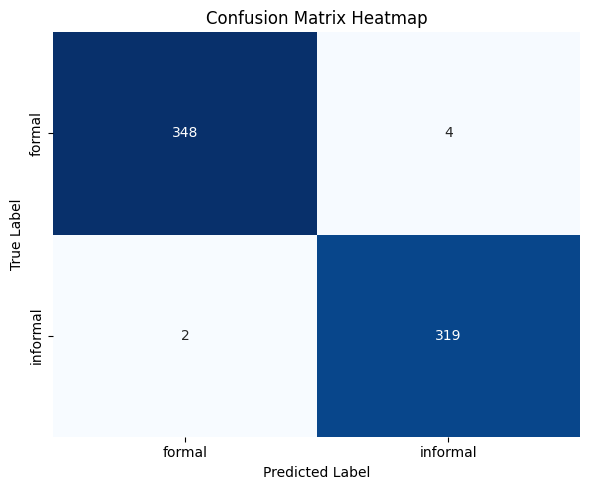

In [14]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["formal", "informal"],
    yticklabels=["formal", "informal"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")

# Save IMAGE to file
plt.tight_layout()
plt.savefig(confusion_mtrx, dpi=300)

plt.show()
plt.close()

In [18]:
from sklearn.metrics import classification_report

# Print the classification report
report = classification_report(y_test, y_pred, target_names=["formal", "informal"])
print(report)

with open(f'{classification_rpt}_{city}.txt', "w") as f:
    f.write(report)

              precision    recall  f1-score   support

      formal       0.99      0.99      0.99       352
    informal       0.99      0.99      0.99       321

    accuracy                           0.99       673
   macro avg       0.99      0.99      0.99       673
weighted avg       0.99      0.99      0.99       673



### REAL DATA

In [19]:
# real data
real_df = pd.read_csv(real_data_file)

print(real_df.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'class', 'geometry', 'polygon',
       'count', 'avg_area', 'max_area', 'avg_height', 'tile',
       'num_pixels_ge_3m'],
      dtype='object')


In [20]:
real_df_adjusted = real_df.drop(
    columns=[
        "Unnamed: 0.1",
        "Unnamed: 0",
        "id",
        "class",
        "geometry",
        "polygon",
        "tile"
    ]
)

real_df_cleaned = real_df_adjusted.fillna(0)

# Normalize data
real_df_cleaned["avg_area_norm"] = real_df_cleaned["avg_area"] / 3000
real_df_cleaned.loc[real_df_cleaned["avg_area"] > 3000, "avg_area_norm"] = 1

real_df_cleaned["max_area_norm"] = real_df_cleaned["max_area"] / 3000
real_df_cleaned.loc[real_df_cleaned["max_area"] > 3000, "max_area_norm"] = 1

real_df_cleaned["avg_height_norm"] = real_df_cleaned["avg_height"] / 100
real_df_cleaned.loc[real_df_cleaned["avg_height"] > 3000, "avg_height_norm"] = 1


real_df_cleaned_adj = real_df_cleaned.drop(columns=["avg_area", "max_area", "avg_height"])
print(real_df_cleaned_adj)

       count  num_pixels_ge_3m  avg_area_norm  max_area_norm  avg_height_norm
0          0                 0       0.000000       0.000000            0.000
1          0                 0       0.000000       0.000000            0.000
2          0                 0       0.000000       0.000000            0.000
3          0                 0       0.000000       0.000000            0.000
4          0                 0       0.000000       0.000000            0.000
...      ...               ...            ...            ...              ...
11654     11               888       0.023893       0.048509            0.045
11655      6               858       0.027299       0.066589            0.050
11656     10               458       0.037904       0.113246            0.045
11657     10              1170       0.021563       0.055189            0.045
11658      4               925       0.048066       0.062426            0.060

[11659 rows x 5 columns]


In [21]:
# Align columns with training data
new_df = real_df_cleaned_adj.reindex(
    columns=X.columns, fill_value=0
)  # Ensure same structure

# Scale using the SAME scaler (don’t fit again)
new_scaled = scaler.transform(new_df)

In [22]:
# Step 1: Predict probabilities
pred_probs = model.predict(new_scaled)

# Step 2: Convert to percentages (e.g., 0.82 → 82.0)
percentages = (pred_probs * 100).round(2).flatten()  # Round to 2 decimal places

# Step 3: Predict binary class from probabilities
pred_classes = (pred_probs > 0.5).astype(int)  # Binary outcome

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


In [23]:
predicted_classes = ["formal" if label == 0 else "informal" for label in pred_classes]
real_df["prediction"] = predicted_classes
real_df["confidence (%)"] = percentages

real_data_adjusted_df = real_df.drop(columns=["class"])

In [24]:
real_data_filtered_df = real_data_adjusted_df[
    real_data_adjusted_df["prediction"] == "informal"
]

# print(real_data_filtered_df["confidence (%)"])

In [25]:
# Convert WKT to shapely geometries
from shapely import wkt

real_data_filtered_df["polygon"] = real_data_filtered_df["polygon"].apply(wkt.loads)

C:\Users\A40589693\AppData\Local\Temp\ipykernel_33568\402012916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_filtered_df["polygon"] = real_data_filtered_df["polygon"].apply(wkt.loads)


In [26]:
# Build GeoJSON features
from shapely.geometry import mapping

color_map = {
    "high": "#00cd00", # green
    "mid": "#ff4d4d", # red
    # "low": "#1591EA", # blue
}     

features = []
for _, row in real_data_filtered_df.iterrows():
    print(row)

    confidence = row["confidence (%)"]
    color = (
        color_map["high"] if confidence > 60
        else color_map["mid"]
    )

    
    feature = {
        "type": "Feature",
        "properties": {
            "id": row["id"],
            "confidence": round(row["confidence (%)"], 2),
            "class": row["prediction"],
            # "trees": row["num_pixels_ge_3m"],
            "fill": color,
            "stroke": color
        },
        "geometry": mapping(row["polygon"]),
    }
    features.append(feature)

Unnamed: 0.1                                                       35
Unnamed: 0                                                         35
id                                 76.5740282952952:8.882677052377803
geometry            {"type": "Feature", "geometry": {"type": "Poly...
polygon             POLYGON ((76.5744796642952 8.882677052377803, ...
count                                                              24
avg_area                                                    47.997988
max_area                                                      89.1291
avg_height                                                        7.5
tile                                                        123321122
num_pixels_ge_3m                                                   88
prediction                                                   informal
confidence (%)                                              96.400002
Name: 35, dtype: object
Unnamed: 0.1                                                      

In [27]:
# Wrap in a FeatureCollection
geojson_dict = {"type": "FeatureCollection", "features": features}

In [28]:
# Save to file
import json

with open(output_file,
    "w",
) as f:
    json.dump(geojson_dict, f, indent=2)